In [8]:
import torch
from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

import model

# LR image size
imageSize = 32
# upSampling from LR image to HR image
upSampling = 4
batchSize = 16
workers = 0
dataroot = './HR_data'
feature_layer = 34 # VGG Feature layer for computing perception loss
# Learning rates and optimizer parameters
beta1 = 0.9
beta2 = 0.999
# G
lr_G = 1e-4
wd_G = 0 # Weight Decay
lmbda = 5e-3
eta = 1e-2
# D
lr_D = 1e-4
wd_D = 0


# random crop for HR images with fixed size
transform = transforms.Compose([transforms.RandomCrop(imageSize*upSampling), transforms.ToTensor()])

# normalize the images
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

# unnormalize the images
unnormalize = transforms.Normalize(mean = [-2.118, -2.036, -1.804], std = [4.367, 4.464, 4.444])

# produce LR images from HR images
scale = transforms.Compose([transforms.ToPILImage(),
                            transforms.Scale(imageSize),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
                            ])

dataset = datasets.ImageFolder(root=dataroot, transform=transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True, num_workers=int(workers))

low_res = torch.FloatTensor(batchSize, 3, imageSize, imageSize)

# Generator
netG = model.RRDB_Net(3, 3, 64, 23, gc=32, upscale=4, norm_type=None, act_type='leakyrelu', res_scale=1)
# Discriminator
netD = model.Discriminator_VGG_128(3, 64, norm_type='batch', act_type='leakyrelu')
# FeatureExtractor
netF = model.VGGFeatureExtractor(feature_layer=feature_layer, use_bn=False, use_input_norm=True)

device = torch.device('cuda')

netG = netG.to(device)
netD = netD.to(device)
netF = netF.to(device)

# Optimizers
# G
optim_params = []
for k, v in netG.named_parameters():  # can optimize for a part of the model
    if v.requires_grad:
        optim_params.append(v)
    else:
        print('WARNING: params [{:s}] will not optimize.'.format(k))
optimizer_G = torch.optim.Adam(optim_params, lr=lr_G, weight_decay=wd_G, betas=(beta1, beta2))

# D
optimizer_D = torch.optim.Adam(netD.parameters(), lr=lr_D, weight_decay=wd_D, betas=(beta1, beta2))

# Loss functions
cri_gan = torch.nn.BCEWithLogitsLoss()
cri_pix = torch.nn.L1Loss()
cri_fea = torch.nn.L1Loss()


print('Start training')

for i, data in enumerate(dataloader):
    high_res_real, _ = data

    # Downsample images to low resolution
    for j in range(batchSize):
        low_res[j] = scale(high_res_real[j])
        high_res_real[j] = normalize(high_res_real[j])
                 
    # Generator
    for p in netD.parameters():
        p.requires_grad = False
    
    optimizer_G.zero_grad()
    
    high_res_real = Variable(high_res_real.cuda())
    high_res_fake = netG(Variable(low_res).cuda())
    
    l_g_total = 0
    
    # L1Loss
    l_g_pix = eta * (cri_pix(high_res_fake, high_res_real))
    
    l_g_total += l_g_pix
    
    # Feature loss
    real_fea = netF(high_res_real).detach()
    fake_fea = netF(high_res_fake)
    l_g_fea = cri_fea(fake_fea, real_fea)
    
    l_g_total += l_g_fea
    
    # Relativistic GAN Loss
    pred_g_fake = netD(high_res_fake)
    pred_d_real = netD(high_res_real).detach()
    
    # cri_gan gives error
#     l_g_gan = lmbda * (cri_gan(pred_d_real - torch.mean(pred_g_fake), False) +
#                         cri_gan(pred_g_fake - torch.mean(pred_d_real), True)) / 2
#     l_g_total += l_g_gan
    
    
    # Backpropagation and update
    l_g_total.backward()
    optimizer_G.step()
    
    # Discriminator
    for p in netD.parameters():
        p.requires_grad = True
    
    optimizer_D.zero_grad()
    l_d_total = 0
    pred_d_real = netD(high_res_real)
    pred_d_fake = netD(high_res_fake.detach())  # detach to avoid BP to G
#     l_d_real = cri_gan(pred_d_real - torch.mean(pred_d_fake), True)
#     l_d_fake = cri_gan(pred_d_fake - torch.mean(pred_d_real), False)
    
#     l_d_total = (l_d_real + l_d_fake) / 2

#     l_d_total.backward()
    optimizer_D.step()
    
    '''
    to do: training
    '''
print('End training')

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


Start training
End training


In [93]:
# display original HR image
img = to_pil(unnormalize(high_res_real.data[-1]))

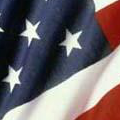

In [94]:
img

In [95]:
# display downsampled LR image
img = to_pil(unnormalize(low_res[-1]))

In [96]:
img